# 4. FINE TUNING DI UN LANGUAGE NEURAL MODEL PRE-ALLENATO

L'obbiettivo è la scelta di un neural language model fornito dalla libreria Hugging Face e un procedimento di fine-tuning per l'addestramento del modello sui dati annotati e la sua specializzazione nella classificazione dell'ironia.

***


### Impostazioni

In [26]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jul  9 10:12:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |   3217MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install --upgrade accelerate

In [28]:
import torch
import datasets
import pandas as pd
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


### Pre-processing

In [29]:
#si carica il dataset
drive.mount('/content/drive')
data_folder = "/content/drive/My Drive/LCII_project/data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
training_set = pd.read_csv(f'{data_folder}/training_ironita2018_anon_REV_.csv', sep=";")
training_set.head()

,id,text,irony,sarcasm,topic
0,811156813181841408,"Zurigo, trovato morto il presunto autore della...",0,0,HSC
1,811183087350595584,"Zurigo, trovato morto il presunto autore della...",0,0,HSC
2,826380632376881152,"Zingari..i soliti ""MERDOSI""..#cacciamolivia Ro...",0,0,HSC
3,844871171350802432,"Zingari di merda,tutti al muro...bastardi Spar...",0,0,HSC
4,509712824361570304,zero notizie decreto #tfaordinario II ciclo ze...,1,0,TW-BS


In [31]:
test_set = pd.read_csv(f'{data_folder}/test_gold_ironita2018_anon_REV_.csv', sep=";")
test_set.head()

,id,text,irony,sarcasm,topic
0,595524450503815168,-Prendere i libri in copisteria-Fare la spesa-...,1,0,TWITA
1,578468106504433665,...comunque con una crociera Costa se non ti a...,1,0,HSC
2,577791521174466560,"“<MENTION_1> Ogni ragazza: \""non sono una raga...",1,1,TWITA
3,507464919303069697,“La buona scuola”? Fa gli errori di grammatica...,0,0,TW-BS
4,839896135619727362,“Vi hanno sfrattato? Andate al campo rom in un...,0,0,HSC


In [32]:
#funzione che sistema il dataframe per l'utilizzo, si mantiene solo id, testo e etichetta
def adapt_df(df):
  df.drop(['sarcasm', 'topic'], axis=1, inplace=True)
  df.rename(columns={'irony': 'label'}, inplace=True)


adapt_df(training_set)
adapt_df(test_set)
test_set.head()

,id,text,label
0,595524450503815168,-Prendere i libri in copisteria-Fare la spesa-...,1
1,578468106504433665,...comunque con una crociera Costa se non ti a...,1
2,577791521174466560,"“<MENTION_1> Ogni ragazza: \""non sono una raga...",1
3,507464919303069697,“La buona scuola”? Fa gli errori di grammatica...,0
4,839896135619727362,“Vi hanno sfrattato? Andate al campo rom in un...,0


In [33]:
# Si trasforma l'oggetto dataframe in un oggetto dataset
train = datasets.Dataset.from_pandas(training_set)
test = datasets.Dataset.from_pandas(test_set)
train_dev = train.train_test_split(test_size=0.33)
train = train_dev["train"]
dev = train_dev["test"]

In [34]:
print(train)

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 2664
})


In [35]:
#si carica il modello transformer pre-addestrato
model_name = 'dbmdz/bert-base-italian-cased'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

In [37]:
#funzione che tokenizza i post 
def tokenize(batch):
   tokens = tokenizer(batch['text'], padding=True, truncation=True, max_length=24)
   return tokens

train = train.map(tokenize, batched=True)
dev = dev.map(tokenize, batched=True)
test = test.map(tokenize, batched=True)


Map:   0%|          | 0/2664 [00:00<?, ? examples/s]

Map:   0%|          | 0/1313 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [38]:
#per training, validation e test si trasformano i dataset nel formato adatto
train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
dev.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

### Training

Per fare fine-tuning del modello Bert si esegue un ciclo di training sull'intero training set per 5 epoche. 

In [39]:
#argomenti per model selection
args = {"batch_size": 32, "learning_rate": 1e-5, "weight_decay": 0.2}

#argomenti per il training del modello
training_args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy = "epoch",
    logging_steps=10,
    learning_rate=args["learning_rate"],
    per_device_train_batch_size=args["batch_size"],
    per_device_eval_batch_size=args["batch_size"],
    num_train_epochs=5,
    weight_decay=args["weight_decay"],
    load_best_model_at_end=True,
)

In [40]:
#funzione per calcolare le metriche
def compute_metrics(preds):
  metrics = evaluate.load("glue", "mrpc")
  predictions, labels = preds
  predictions = np.argmax(predictions, axis=1) #applichiamo argmax per scegliere la classe con probabilità più alta per fare il confronto con le labels
  scores = metrics.compute(predictions=predictions, references=labels)
  return scores

In [41]:
#si definisce un oggetto di classe trainer con gli argomenti definiti prima
trainer = Trainer(
    model,
    training_args,
    train_dataset=train,
    eval_dataset=dev,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [42]:
#sia allena il modello
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.658200,0.604695,0.676314,0.711864
2,0.588200,0.574418,0.701447,0.708767
3,0.534100,0.560603,0.717441,0.735567
4,0.496800,0.562908,0.722011,0.700574
5,0.470000,0.555620,0.722772,0.713386


TrainOutput(global_step=420, training_loss=0.5494288035801479, metrics={'train_runtime': 122.7142, 'train_samples_per_second': 108.545, 'train_steps_per_second': 3.423, 'total_flos': 164279965190400.0, 'train_loss': 0.5494288035801479, 'epoch': 5.0})

### Validation

Si valuta il modello sulla base delle metriche e delle curve di Loss.

In [43]:
#funzione per ottenere un dizionare con tutte le informazioni e le metriche per ogni epoca
def newdict(log):
  i = 1
  all_logs=[]
  new_log={}
  for x in log:
    if i == 1:
      new_log = x
      i+=1
    else:
      new_log.update(x)
      all_logs.append(new_log)
      i-=1
  return all_logs

In [44]:
log_history = trainer.state.log_history
log_history = newdict(log_history)
log_df = pd.DataFrame(log_history)
log_df.head()

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.6582,0.000008,1.0,84,0.604695,0.676314,0.711864,2.2128,593.359,18.980
1,0.5882,0.000006,2.0,168,0.574418,0.701447,0.708767,2.1756,603.511,19.305
2,0.5341,0.000004,3.0,252,0.560603,0.717441,0.735567,2.0520,639.873,20.468
3,0.4968,0.000002,4.0,336,0.562908,0.722011,0.700574,2.0595,637.540,20.394
4,0.4700,0.000000,5.0,420,0.555620,0.722772,0.713386,2.1511,610.377,19.525


In [45]:
#si salvano i risultati in un file di testo
with open('results_4.txt', 'a') as file:
    file.write(f'Configurazione: Batch-size = {args["batch_size"]}, Learning-rate = {args["learning_rate"]}, Weight-decay = {args["weight_decay"]}\n')
    file.write(f'Training loss:\n {log_df["loss"]}\n Validation loss:\n {log_df["eval_loss"]}\n F1-score:\n {log_df["eval_f1"]}\n Accuracy:\n {log_df["eval_accuracy"]}\n')
    file.write("------------------------------------------------------------------------------------------\n")

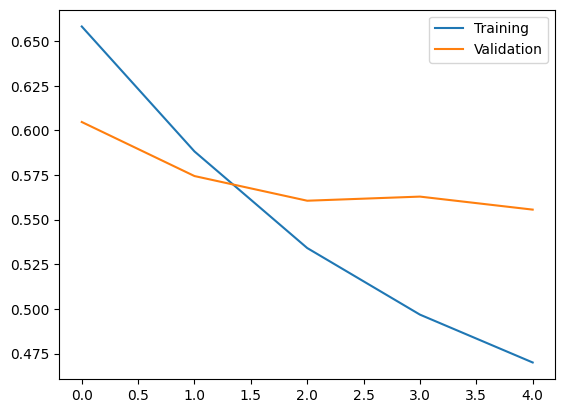

In [46]:
#si prendono i valori di loss sia per train che per validation
training_losses = log_df["loss"]
eval_losses = log_df["eval_loss"]

#si plottano le curve di loss
plt.plot(training_losses, label="Training")
plt.plot(eval_losses, label="Validation")
plt.legend(loc='upper right')
plot_name = f'batch-{args["batch_size"]}__lr-{args["learning_rate"]}__wd-{args["weight_decay"]}.png'
plt.savefig(plot_name)
plt.show()

### Test

Una volta fatto il fine-tuning si passa al test del modello sul test set ufficiale

In [47]:
#si estraggono le prediction sul test set del modello fine-tunato sul 
test_preds = trainer.predict(test)

In [48]:
test_labels = test["label"].tolist()

In [49]:
#si calcolano le metriche di valutazione per il test
test_preds = np.argmax(test_preds.predictions, axis=1)
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.71      0.60      0.65       437
           1       0.65      0.75      0.70       435

    accuracy                           0.68       872
   macro avg       0.68      0.68      0.67       872
weighted avg       0.68      0.68      0.67       872



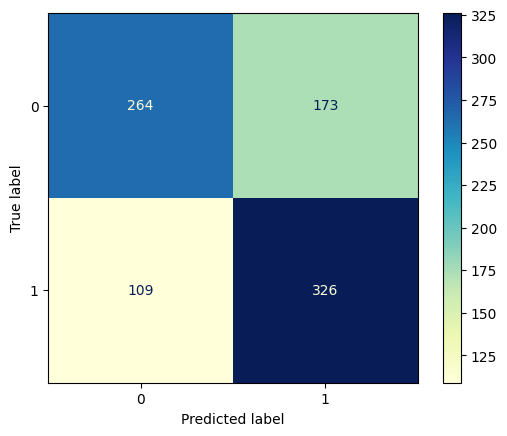

In [50]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, cmap="YlGnBu")